# Practical 10 - Predictive Modelling (Part II)

The objective is to practice on tree-based and ensemble models and identify their strengths and weaknesses in application in comparison to SVM-based models discussed in the lecture. You will also have some hands on experience on regression models that were covered in the lectures espcially the sparse linear regression. Finally you will experience the importance of feature pre-processing for practical classification tasks. 

For this practical, again your task is to review this notebook. All code blocks can be executed if there is no instruction asking for your code. You do need to read the notebook carefully and test everything by yourself.  Make sure you understand everything before continuing with the questions at the end and the final coding task.  

*N.B. all code blocks have to be excuted in sequel. If you encounter any difficulties, run the code from the very first block. In the final coding task, __DO NOT__ assume any preloaded packages or data set other than those appear in coding task blocks!*

## Classification (cont.)
You will also need two moons training and test data (`moon_training.csv` and `moon_testing.csv` used last week. Please find them in last week prac class folder on vUWS. 

Much like last week, you will not be required to write any code to perform the analysis. Instead, you will have to understand how it works and answer questions based on it and its outputs. 

We start with loading packages for our analysis. 

In [8]:
%matplotlib inline
from sklearn.datasets import make_moons
from sklearn.svm import LinearSVC, SVC
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from mlxtend.evaluate import plot_decision_regions
#from mlxtend.plotting import plot_decision_regions
import mlxtend.plotting.plot_decision_regions as plot_decision_regions

SyntaxError: invalid syntax (heatmap.py, line 74)

## Two Moons Dataset

Here we are using the same two moons example from last week. Ensure that `moon_training.csv` and `moon_testing.csv` are in the same path as this notebook, or adjust the file paths in the cell below as necessary.

In [5]:
training_moon = pd.read_csv('moon_training.csv')
testing_moon = pd.read_csv('moon_testing.csv')

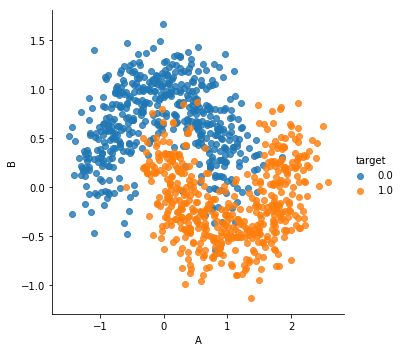

In [6]:
sns.lmplot(x='A', y='B', data=training_moon, hue='target', fit_reg=False)

For the sake of convenience, we only showed the training dataset above, but testing dataset can be plotted similarly .

In the following code block, we train a kernel SVM model to separate examples from two classes with different colors and also plot the decision boundary.  

In [9]:
# give an easier to read name to the datasets
training_data = training_moon[['A','B']]
training_target = training_moon['target']
testing_data = testing_moon[['A','B']]
testing_target = testing_moon['target']

# train and test kernel svm classifier
clf_kernel = SVC()
clf_kernel.fit(training_data, training_target)
clf_kernel_accuracy = clf_kernel.score(testing_data, testing_target)*100
print('Accuracy of Kernel SVM =', clf_kernel_accuracy, '%')

ax = plot_decision_regions(training_data.values, training_target.values.astype(int), clf=clf_kernel, legend=2)
ax.set_title('Kernel SVM')
ax.set_xlabel('x')
ax.set_ylabel('y')


('Accuracy of Kernel SVM =', 93.4, '%')


NameError: name 'plot_decision_regions' is not defined

Next, we experiment with the decision tree classifier, which recursively partitions the space such that the samples with the same labels are grouped together. In this case, it recursively splits the space into two regions along the x and y axis. The depth of the tree, i.e. the maximum number of splits allowed, controls the complexity of the tree classifier. The deeper the tree, the more levels and splits, the more complex the tree classifier, but it is also more likely to overfit the training data. On the other hand, a shallow tree with small depth may not be complex enough to deal with the non-linearity in the data. 

First, we test a decision tree with depth 1 (just one cut along x or y direction). This is expected to produce poor result. Try executing the following code block **multiple times** and observe the results. 

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# create a decision tree with depth 1, max_depth=1
print('Training decision tree with depth 1')
clf_tree = DecisionTreeClassifier(max_features=1, max_depth=1)
clf_tree.fit(training_data, training_target)
print('Accuracy = %.2f%%'  % (clf_tree.score(testing_data, testing_target)*100))

ax = plot_decision_regions(training_data.values, training_target.values.astype(int), clf=clf_tree, legend=2)
ax.set_title('Decision Tree (d=1)')
ax.set_xlabel('x')
ax.set_ylabel('y')


Unlike the SVM classification model, which obtains quite stable results over multiple runs, *the decision tree has a random nature and may obtain different results for different runs*. For above example, we have set the maximum number of features to best tested during the split process to 1 (max_features=1). This means, for different runs, a different direction might be chosen for spliting the feature space. Hence, you can see that sometimes the space is splitted vertically (along x direction), and sometimes is splitted horizontally. You can simple use the default value for max_features, i.e `max_features=None`, which basically takes all features available and this problem will disappear. 

By increasing the depth of the tree classifier, we can produce more sophisticated decision boundaries and achieve improved accuracies. The following code demonstrates this by testing different tree depths of 2, 4, 8 and 16. 

In [ ]:
# test depths = 2, 4, 8, 16
for depth in [2,4,8,16]:
    print('Training decision tree with depth %d' % depth )
    clf = DecisionTreeClassifier(max_features=1, max_depth=depth, min_samples_leaf=1)
    clf = clf.fit(training_data, training_target)
    print('Accuracy = %.2f%%' % (clf.score(testing_data, testing_target)*100))
    plt.clf()
    ax = plot_decision_regions(training_data.values, training_target.values.astype(int), clf=clf, legend=2)
    ax.set_title('Decision Tree (d=%d)'%depth)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

Though decision tree classifier gets more powerful by increasing the depth, the decision boundaries generated by the classification model also becomes quite spiky as can be observed from the above demonstration. This is mainly because the tree classifier is limited to axis-parallel directions for each split, and potentially many splits are needed to model complex data distrbutions making the resulting decision boundary excessively spiky. <font color=blue>*This usually indicates overfitting as the trees are developed to model every data sample*</font>. To overcome this issue and produce smoother boundaries, we can use some heuristics, such as tree pruning (not implemented with scikit-learn package though) and early stopping (do not split the region if it contains less than a threhold number of examples. The threshold can be set with *min_samples_leaf* parameter). The *min_samples_leaf* parameter value is 1 by default. Try setting this parameter to larger values for the above example and check the differences in results.

Moreover, by executing the above block multiple times, you might notice that the performance of decision tree classifier does not always improve with increasing depth. Sometimes overfitting occurs with larger depth. Technically, we need to select the optimal depth for decision tree classifier using the cross validation technique discussed during the lecture and practical class last week. 

A more principled approach for achieving smoother decision boundaries and further improvement in performance is to use an ensemble model - a classification model that combines individual classifiers. The **random forest classifier**, which is an ensemble model for a collection of decision trees, is based on the decision tree but more powerful due to the use of multiple trees. 

We test the performance of random forest classifier on the two moons dataset in the following cell.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

num_trees = 100
print('Training random forest classifier')
clf_forest = RandomForestClassifier(n_estimators = num_trees, min_samples_leaf=1, max_features=1, max_depth=16)
clf_forest.fit(training_data, training_target)
print('Accuracy = %.2f%%' % (clf_forest.score(testing_data, testing_target)*100))
# plot decision boundary
ax = plot_decision_regions(training_data.values, training_target.values.astype(int), clf=clf_forest, legend=2)
ax.set_title('Random Forest (%d trees)'%num_trees)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

As you can see, the random forest classifier produces quite smooth decision boundary compared to decision trees. Sometimes its classification performance is even better than kernel SVM! Furthermore, it is much more efficient for training random forest classifiers compared to kernel SVM. From the previous practical, we know that kernel SVM is slower than the linear SVM due to the nonlinear decision function it solves. In the next example, we will show that random forest classifier is even faster than linear SVM for large problems, making it a very useful classification model for practical applications. 

The performance of random forest classifier depends on the number of trees used in the forest. This can be set with the *n_estimator* parameter (10 by default). We have used 100 trees in the above example. However, the results are not overly sensitive with this parameter as long as sufficient number of trees is used. Moreover, unlike decision tree classifiers which overfit with large depth value, random forest classifiers are unlikely to overfit with large number of trees due to the use of the ensemble (collection). This is also a desirable feature of random forest classifier. In practice, we can just set *n_estimator* to a large value and let the classification model do the magic for us. To show this, you can try different values of *n_estimator*  for the above example and observe the results. Notice, however, that a large value for the *n_estimator* parameter does make it slower for training and prediction. 

## Regression 
Before we move onto regression, we sort out connection to `R` first. Here we assume you have `R` installed on your computer. If you don't, please go to http://r-project.org and install a corret version of `R` for your computer platform. Or alternatively, you can simply use hadoop-01.scem.uws.edu.au, the big data machine for this practical. If you use big data machine, you can skip the following installation part and go straight to next code block for regression. 

In python there is a package called `rpy2` which can connect to `R` so that you can do amazing things like using `R` commands and `R` data sets. If you are using python 3 or later version, you can simply use 

```bash 
pip install rpy2
```

to install the package. However, if you use python 2.7.x, then you need to specify the version number to suit the python version as 

```bash 
pip install rpy2==2.7
```
Canopy does not have `rpy2` package. So you need to use command window (for windows) or canopy terminal (for Mac/Linux) to install this package. 

When you sort out `rpy2` package, it is time to move on to the code blocks below. 

In [ ]:
import pandas as pd
import rpy2.robjects as ro
import rpy2.robjects.conversion as conversion
from rpy2.robjects import pandas2ri
pandas2ri.activate()

R = ro.r
# We play with cars data set in R 
cars = conversion.ri2py(R['cars'])
print(cars.head())

You should see the first a few lines of `cars` data set, which is records about speed and stop distance. Now we proceed to apply ordinary least squares to simple linear regression and predict stop distance using speed. 

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

y = np.array(cars['dist'].astype('float'))
x = np.array(cars['speed'].astype('float'))

x_train, x_test, y_train, y_test = train_test_split(x,y,
test_size=0.4,random_state=42)

reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(x_train.reshape(-1, 1),y_train)
y_pred = reg.predict(x_test.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.scatter(x_test, y_test,  color='black')
plt.plot(x_test, y_pred, color='blue', linewidth=3)
plt.xlabel('Speed')
plt.ylabel('Stopping distance')
plt.grid(True)
plt.title('Linear Regression Ordinary Least Squares')
plt.legend(['Model prediction','Observations'])
plt.show()

Stopping distance is a continuous quantity, so regression is the appropriate model for this. From the plot above it shows clearly that linear regression does a pretty good job in getting the stopping distance right.  

Now we look at `diabetes` data which is included in python package `sklearn`. In `diabetes` data, ten baseline variables, _age, sex, body mass index, average blood pressure, and six blood serum measurements_ were obtained for each of $n = 442$ diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline. The research question is to find the relationship between baseline variables (observables) and the disease progression and in turn we can predict the disease progression. One more important question is that actually the progression is _only determined by a couple of observable variables_. 

In [ ]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

In [ ]:
print 'The dimension of diabetes data: '+ str(X.shape) + '\nFirst 3 rows:\n'
print X[range(3),:]

We explore the data a little bit by pairwise scatter plot. 

In [ ]:
import seaborn as sns
df = pd.DataFrame(np.column_stack((X, y)),columns=['age', 'sex', 'body mass index', 'average blood pressure', 's1','s2','s3','s4','s5','s6','Progression'])
sns.pairplot(df)
plt.show()

We apply LASSO to the data, a sparse linear regression as the following. Note that the regularisation parameter, i.e. $\lambda$ in the LASSO model, is arbitarily chosen to be 1.5, it is `alpha` in function `linear_model.Lasso`. So we end up of selecting __2__ varaibles. 

In [ ]:
varnames = ['age', 'sex', 'body mass index', 'average blood pressure', 's1','s2','s3','s4','s5','s6']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=42)
reg = linear_model.Lasso(alpha = 1.5,normalize=True)
reg.fit(X_train,y_train)
print('Selected variables: ',[varnames[i] for i in np.where(reg.coef_!=0)[0]])

But why in particular only 2 varialbes selected in the model? Why not 3, 4 or whatever? This question is essentially a model selection question. In general there should be a true model with a number of variables in the model that dicates the response. However, we never know this true model. There are two issues in the question. The first is how many variables is actually in the model. The second is what are they. Path algorithms can answwer these two in one go. They vary the regularisation parameter(s), do the sparse regression and output the varaibles selected as regularisation progress. Of course, this is done clearly in the path algorithms rather than applying sparse regression on a grid of regularisation parameters.   

The following code demonstrates two path algorithms, LASSO path algorithm and elastic net path algorithm and their corresponding nonnegative version, i.e. constraining the regression coefficients to be nonnegative. The code plots the path. The vertical lines in the plots show the places where the set of selected variables changes. 

In [ ]:

X /= X.std(axis=0)  # Standardize data (easier to set the l1_ratio parameter)

# Compute paths

eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps, fit_intercept=False)

print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(
    X, y, eps, positive=True, fit_intercept=False)
print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, fit_intercept=False)

print("Computing regularization path using the positive elastic net...")
alphas_positive_enet, coefs_positive_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, positive=True, fit_intercept=False)

# Display results

plt.figure(1)
ax = plt.gca()

colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')


plt.figure(2)
ax = plt.gca()
neg_log_alphas_positive_lasso = -np.log10(alphas_positive_lasso)
for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_positive_lasso, coef_pl, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and positive Lasso')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'positive Lasso'), loc='lower left')
plt.axis('tight')


plt.figure(3)
ax = plt.gca()
neg_log_alphas_positive_enet = -np.log10(alphas_positive_enet)
for (coef_e, coef_pe, c) in zip(coefs_enet, coefs_positive_enet, colors):
    l1 = plt.plot(neg_log_alphas_enet, coef_e, c=c)
    l2 = plt.plot(neg_log_alphas_positive_enet, coef_pe, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic-Net and positive Elastic-Net')
plt.legend((l1[-1], l2[-1]), ('Elastic-Net', 'positive Elastic-Net'),
           loc='lower left')
plt.axis('tight')
plt.show()

The above shows that path algorithms are capable of finding all sets of selected variables with different sizes. But which set is the truth? This remains an open problem. Current solution is cross validation. 

## Feature Preprocessing: Census Income Example

In this exercise, we will work on a census income example to predict wether a person makes over $50,000K a year based on census information such as age, workclass, years of education, marital status, etc. The dataset can be downloaded from the vUWS site that contains a training data file **adult.trn** and a testing data file **adult.tst**. Copy these two data files to where this notebook is being saved and load the datasets by the following statements

In [ ]:
print('Reading datasets...')
df_trn = pd.read_csv('adult.trn', index_col=False, skipinitialspace=True)
df_tst = pd.read_csv('adult.tst', index_col=False, skipinitialspace=True) 
print('Done')

In [ ]:
# inspect the data
df_trn

The training data (*df_trn*) contains 30162 rows and 13 columns. Each row corresponds to a training example and each column maps to an input feature, except the last column (salary) which represents the target label value to be predicted. This is a typical binary classification problem. The purpose is to predict whether a person makes >50K given the census information. 

Since the input features are mixed with columns of numbers and strings (the latter is known as nominal features), we first have to convert the nominal features to numbers in order to use existing classification methods. This can be done with two encoding schemes. The first one is a standard **substitution scheme** that replaces each unique string value to a different number like 0, 1, 2, etc. The second one uses the more sophistated strategy based on **one-of-K encoding** (sometimes called one-hot encoding), that uses a K-vector to represent a single nominal feature with K different values. Each location in the K-vector correponds to one of the values and is set to 1 if the feature takes that value and 0 otherwise.

To illustrate this point, we use the race feature as an example. To get a list of unique values for race feature, we can use the following command

In [ ]:
df_trn['workclass'].unique()

With the first scheme, we use **0, 1, 2, 3, 4** to represent **White, Black, Asian-Pac-Islander, Amer-Indian-Eskimo** and **Other** respectively. With the second scheme, we use **[1,0,0,0,0]** to represent **White**, **[0,1,0,0,0]** to represent **Black**, etc. In the following, we will try both encoding schemes for training our classification models to identify their respective strengths and limitations. 

### Substitution Scheme

First, we will test the performances of different classification models with the substitution scheme for feature value conversion. The following code block generates two new data frames, **df_trn_subst** and **df_tst_subst**,  that replace the old training data frame **df_trn** and testing data frame **df_tst** respectively, where all nominal features have been converted into numerical values. We use a class from Scikit Learn named `LabelEncoder` which accepts catagorical data and substitutes the values with integers. This class is intended to be used for labels (targets) but we use it here on features as a demonstration.

In [ ]:
from sklearn.preprocessing import LabelEncoder
ALL_COLS = set(df_trn.columns)
NUMERIC_COLS = set(['age', 'fnlwgt', 'years-of-edu', 'capital-gain', 'capital-loss', 'hours'])  # cols with numerical data
CATAGORICAL_COLS = ALL_COLS - NUMERIC_COLS - set(['salary'])  # catagorical columns, excluding the target (salary)
df_trn_subst = df_trn.copy()
df_tst_subst = df_tst.copy()
for column in df_trn.drop(NUMERIC_COLS, axis=1).columns:
    le = LabelEncoder()
    le.fit_transform(df_trn[column].append((df_tst[column]))) # Just to ensure that LabelEncoder has seen all labels
    df_trn_subst[column] = le.transform(df_trn[column])
    df_tst_subst[column] = le.transform(df_tst[column])

We can now examine the content of the new dataframes processed by the simple substitution schem by (again, we only check the trainining dataset **df_trn_subst**, and testing dataset **df_tst_subst** can be checked in the same way)

In [ ]:
df_trn_subst

It can be seen that all entries have been converted to numerical values. We can now apply the standard classification model to the above problem to fit the last column of target values to other columns of feature values.

Firstly, we try the SVM classifier discussed in last week's lecture. Due to the size of the problem (>30,000 examples), we use the linear SVM classifier for the purpose of efficiency. For output result, we show both predictive accuracy and training speed measured by the number of seconds it takes for model training.

Execute the next block multiple times to observe the results.

In [ ]:
from time import time 

print('Extracting data...')
# split the dataframes into the features and labels (i.e. the salary column)
training_features, training_labels = df_trn_subst.drop(['salary'], axis=1), df_trn_subst['salary']
testing_features, testing_labels = df_tst_subst.drop(['salary'], axis=1), df_tst_subst['salary']

print('Training Linear SVM classifier...')
start = time()
clf = LinearSVC()
clf.fit(training_features, training_labels)
end = time()

print('Accuracy = %.2f%% in %.2f seconds' % (clf.score(testing_features, testing_labels)*100, end-start))

As you can see, every time you execute the code for training linear SVM, the accuracy value achieved is different. Most time it produces accuracy value of >75%. Sometimes you get a very poor accuracy (<50%). Why does this happen?

This happens due to numerical instability caused by the different scales of input features. By spotting the values for df_trn_subst from the previous table, we see that some columns have large values (fnlwgt and capital-gain), whereas others have relatively smaller values. This causes problem to classifier training that involves using a numerical method. To solve this problem, we need to preprocess the data to ensure each column has the same scale of values. In the following, we applied linear SVM to pre-processed features, where each feature is scaled to have zero mean and unit standard deviation.

In [ ]:
from sklearn.preprocessing import StandardScaler

# apply feature transformation so that values from each column are scaled to zero mean and unit standard deviation
scaler = StandardScaler().fit(training_features)
training_features_scaled = scaler.transform(training_features)
testing_features_scaled = scaler.transform(testing_features)

print('Training Linear SVM on pre-processed features...')
start = time()
clf = LinearSVC()
clf.fit(training_features_scaled, training_labels)
end = time()
print('Accuracy = %.2f%% in %.2f seconds' % (clf.score(testing_features_scaled, testing_labels)*100, end-start))

As you can see from the above results, a linear SVM classification model trained on the pre-processed data achieves **better** results than direct application of the classifier on raw input data. The results are also quite stable. If you execute the above code block multiple times, the accuracy values obtained are all quite similar. This demonstrates the importance of feature pre-processing for both performance and stability.

Interestingly, tree-based classification models such as the decision tree classifier and the random forest classifier, which is an ensemble of decision trees, are not affected by the scale of input features. To show this, we train a random forest classifier with 100 decision trees for both raw and pre-processed features in the following and compare their performances. We have empirically set the minimum sample size to 5 for each leave node (min_samples_leaf=5), and the maximum depth of each tree to 16 (max_depth=16). Feel free to play with these parameter values for performance comparison. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# create a random forest classifier
print('Training random forest classifier on raw features...')
start = time()
clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, max_features='auto', max_depth=16)

# train and test random forest classifier on raw input features
clf.fit(training_features, training_labels)
end = time()

print('Accuracy = %.2f%% in %.2f seconds' % (clf.score(testing_features, testing_labels)*100, end-start))

# train and test random forest classifier on pre-processed features
print('Training random forest classifier on pre-processed features...')
start = time()
clf.fit(training_features_scaled, training_labels)
end = time()
print('Accuracy = %.2f%% in %.2f seconds' % (clf.score(testing_features_scaled, testing_labels)*100, end-start))

The results with random forest classifier for different input are not much different. This indicates that tree-based classification models are not overly sensitive to different scales of input data. 

### One-Of-K Encoding Scheme

In the following, we test the one-of-K encoding scheme, which converts each column of nominal feature into K columns of numerical values representing K possible nominal feature values. The following cell uses a Pandas function named `get_dummies`, which converts catagorical values into indicator values. This is exactly what One-of-K encoding is. e.g. the _relationship_ column will be converted into 6 columns: Not-in-family, Husband, Wife, Own-child, Unmarried, Other-relative with 1 stored in the column for the value that is true.

In order for `get_dummies` to work properly, we will need to temporarily combine the training and testing datasets so that no values are missed in the one-of-K encoding. This could occur if no samples in the training dataset contain a value that is present in the testing dataset e.g. if no one in the training dataset has a relationship status of _Wife_, then the one-of-K encoding will not make a column for the _Wife_ value. We can do this with another Pandas function named `concat`.

In [ ]:
# combine training and testing datasets temporarily for one-of-K encoding
# only encode the columns listed in CATAGORICAL_COLS
df_dummies = pd.get_dummies(pd.concat([df_trn, df_tst], axis=0), columns=CATAGORICAL_COLS)

train_rows = df_trn.shape[0]  # number of training dataset rows

# split the dataset back into training and testing
df_train_oneofk = df_dummies.iloc[:train_rows, :]
df_test_oneofk = df_dummies.iloc[train_rows:, :] 

Now you can view the new training data frame **df_train_oneofk** by typing it directly (**df_test_oneofk** can be shown in the same way). You can scroll the horizontal scroll bar in the bottom to view more columns. 

Next, we train two classification models, the linear SVM and random forest classifier, respectively on the new data frames obtained above. From previous example, we know that numerical features must be pre-processed to have the same scale for linear SVM training, but there is no need to pre-process features for random forest. 

In [ ]:
# get training and testing examples and labels from respective data frames
training_features, training_labels = df_train_oneofk.drop(['salary'], axis=1), df_train_oneofk['salary']
testing_features, testing_labels = df_test_oneofk.drop(['salary'], axis=1), df_test_oneofk['salary']

In [ ]:
# random forest
print('Learning random forest classifier on raw features...')
start = time()
clf = RandomForestClassifier(n_estimators = 100, min_samples_leaf=5, max_features='auto', max_depth=16)
clf.fit(training_features, training_labels)
end = time()
print('Accuracy = %.2f%% in %.2f seconds' % (clf.score(testing_features, testing_labels)*100, end-start))

In [ ]:
# SVM, need feature scaling
print('Learning SVM classifier on pre-processed features...')
# apply feature scaling
start = time()
scaler = StandardScaler().fit(training_features)
training_features_scaled = scaler.transform(training_features)
testing_features_scaled = scaler.transform(testing_features)
# training and testing SVM
clf = LinearSVC()
clf.fit(training_features_scaled, training_labels)
end = time()
print('Accuracy = %.2f%% in %.2f seconds' % (clf.score(testing_features_scaled, testing_labels)*100, end-start)   )

It can be seen that classification models trained on features obtained from the One-Of-K encoding scheme achieve better performances than models trained with the substitution scheme with increasing accuracy values. This is more obvious with the linear SVM classification model, which obtains about almost 3% improvement on accuracy (84.8% vs 82.07%). Speedwise, One-Of-K encoding scheme is slower than substitution scheme in training, because more columns are generated with the one-of-K encoding which increases the number of input features. With both encoding schemes, random forest classifier is able to outperform the linear SVM model in terms of both training speed and accuracy, demonstrating the effectiveness and efficiency of tree-based classification models for this classification task.  

## Questions

Answer each of the questions below using the examples and code provided above. Double click this cell and then edit the text below after each question. 

1. How does increasing the depth of the decision tree classifier affect its performance?

2. What is the problem with decision tree classifier when applying it applied to the two moons dataset? Does random forest classifier have the same problem? Why?

3. Try running the random forest classifier multiple times on the two moons dataset with different numbers of trees (e.g. by changing the value of the num_trees variable to 10, 20, 50, 100, 200, 500, 1000, 2000).  How does increasing the number of trees affect the performances of random forest classifier?

4. How many training examples are there for the census income dataset? What are the features for the census data? What is the purpose of prediction?

5. For the substitution and one-of-K schemes for converting nominal features into numerical values, which conversion scheme is more effective for predictive modelling? Why?

6. Why we need to apply feature pre-processing to scale the input features into the same range for classification training? Which classification model is more sensitive to different feature ranges? 

7. Which classification model achieves better result with the substitution scheme? How about the one-of-K scheme?

8. Select a classification model for each of the following scenario and justify your choices. 

    a) The dataset contains 2,000 examples with 50 features. All features are numerical values. 

    b) The dataset contains 2,000,000 examples with 50 features. Majority of them are numerical values. 

    c) The dataset contains 20,000 examples with 50,000 features. All features are numerical values. 

    d) The dataset contains 20,000 examples with 10 features. Majority of them are nominal features. 

__<font color=red>Please submit this Jupyter notebook to the tutor's email address.</font> __


# Coding task: apply sparse linear regression to Boston Housing data.
Boston housing data is contained in `sklearn` package. See http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html also https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/Boston.html. The response variable is the median value of owner-occupied homes in \$1000s. The following code load the data in and print the shape of the predictors, `X` and response `y`. 

In [ ]:
from sklearn.datasets import load_boston
boston = load_boston()
X = boston.data
y = boston.target
print(X.shape)
print(y.shape)

Use path algorithm to find all possible sets of selected variables. You can go further to do cross validation to select the best model. The normal practice is that when you selected some variables, refit those to the data with an ordinary linear regression and take performance statistics from there. 

### Your code goes from here: 

In [ ]:
# Your python code goes from here. 

<b><font size=5 color='red'>Submit your completed jupyter notebook to your tutor email address!</font></b>